In [78]:
from astropy.table import Table
from astropy.io import fits
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as patches
from glob import glob
import seaborn as sea
import numpy as np
import pandas as pd
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.2, as_cmap=True)

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

%matplotlib inline
%config InlineBackend.figure_format='retina'

ksmooth = importr('KernSmooth')


In [29]:
def Scale_sim(D, M):
    return np.sum(D * M) / np.sum(M ** 2)

In [34]:
cwv,ctrans = np.load('nircam_grismc_trans.npy')
rwv,rtrans = np.load('nircam_grismr_trans.npy')
d_grismr = np.load('nircam_z5.6_d_grismr.npy')
d_grismc = np.load('nircam_z5.6_d_grismc.npy')
m_grismr = np.load('nircam_z5.6_m_grismr.npy')
m_grismc = np.load('nircam_z5.6_m_grismc.npy')

In [69]:
wv = rwv

dgr_fn = d_grismr[1]/rtrans
dgc_fn = (d_grismc[1]/ctrans)[::-1]
mgr_fn = m_grismr[1]/rtrans
mgc_fn = (m_grismc[1]/ctrans)[::-1]

dgr_er = d_grismr[2]/rtrans
dgc_er = (d_grismc[2]/ctrans)[::-1]
mgr_er = m_grismr[2]/rtrans
mgc_er = (m_grismc[2]/ctrans)[::-1]

C1 = Scale_sim(dgr_fn, dgc_fn)
C2 = Scale_sim(dgr_fn, mgr_fn)
C3 = Scale_sim(dgr_fn, mgc_fn)

dgc_fn *=C1 ; dgc_er *=C1
mgr_fn *=C2 ; mgr_er *=C2
mgc_fn *=C3 ; mgc_er *=C3

sim_drfn = dgr_fn + np.random.normal(0,dgr_er)
sim_dcfn = dgc_fn + np.random.normal(0,dgc_er)
sim_mrfn = mgr_fn + np.random.normal(0,mgr_er)
sim_mcfn = mgc_fn + np.random.normal(0,mgc_er)

fn_grid = np.array([sim_drfn, sim_dcfn, sim_mrfn, sim_mcfn])
w_grid = np.array([dgr_er, dgc_er, mgr_er, mgc_er])**(-2)

stack = np.sum(np.array(fn_grid).T * w_grid.T, axis=1) / np.sum(w_grid.T, axis=1)
error = 1 / np.sqrt(np.sum(w_grid.T, axis=1))

In [39]:
print Scale_sim(d_grismr[1]/rtrans, (d_grismc[1]/ctrans)[::-1])
print Scale_sim(m_grismr[1]/rtrans, (m_grismc[1]/ctrans)[::-1])

1.04360286572
1.04360286572


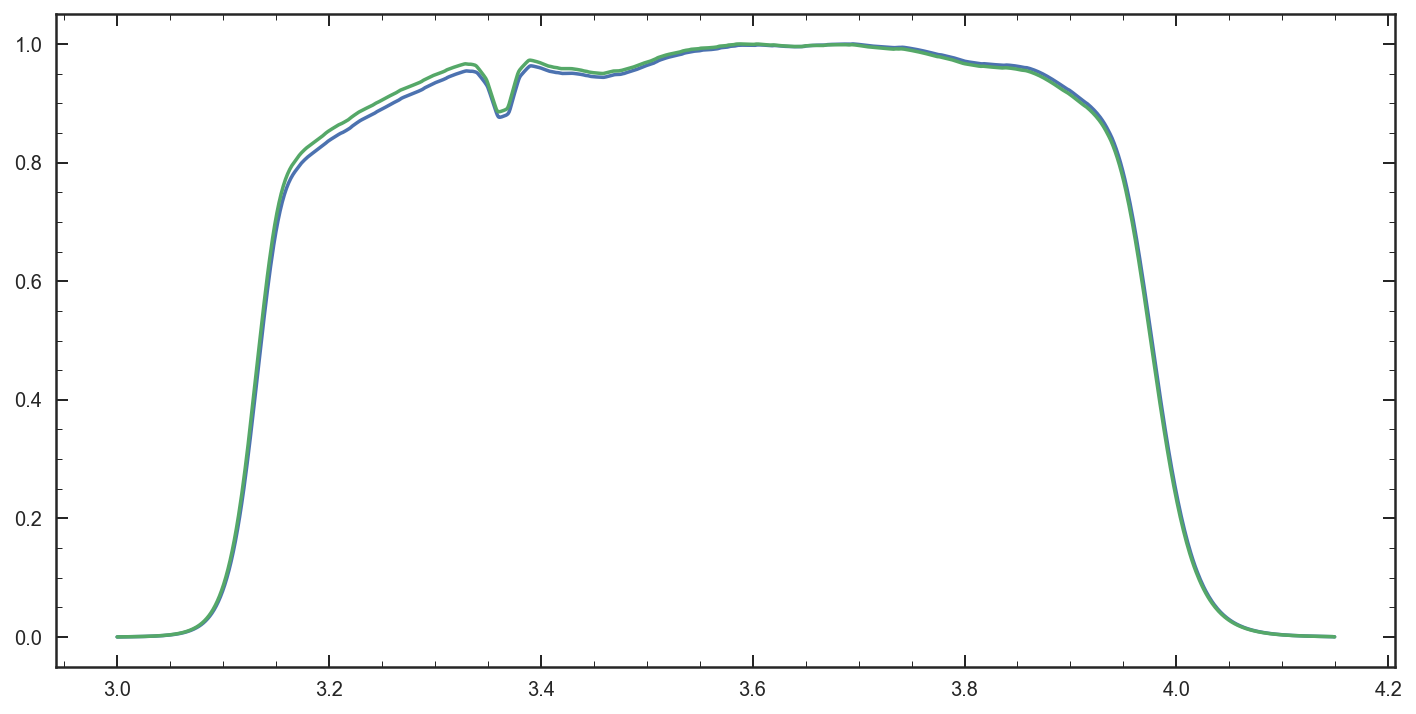

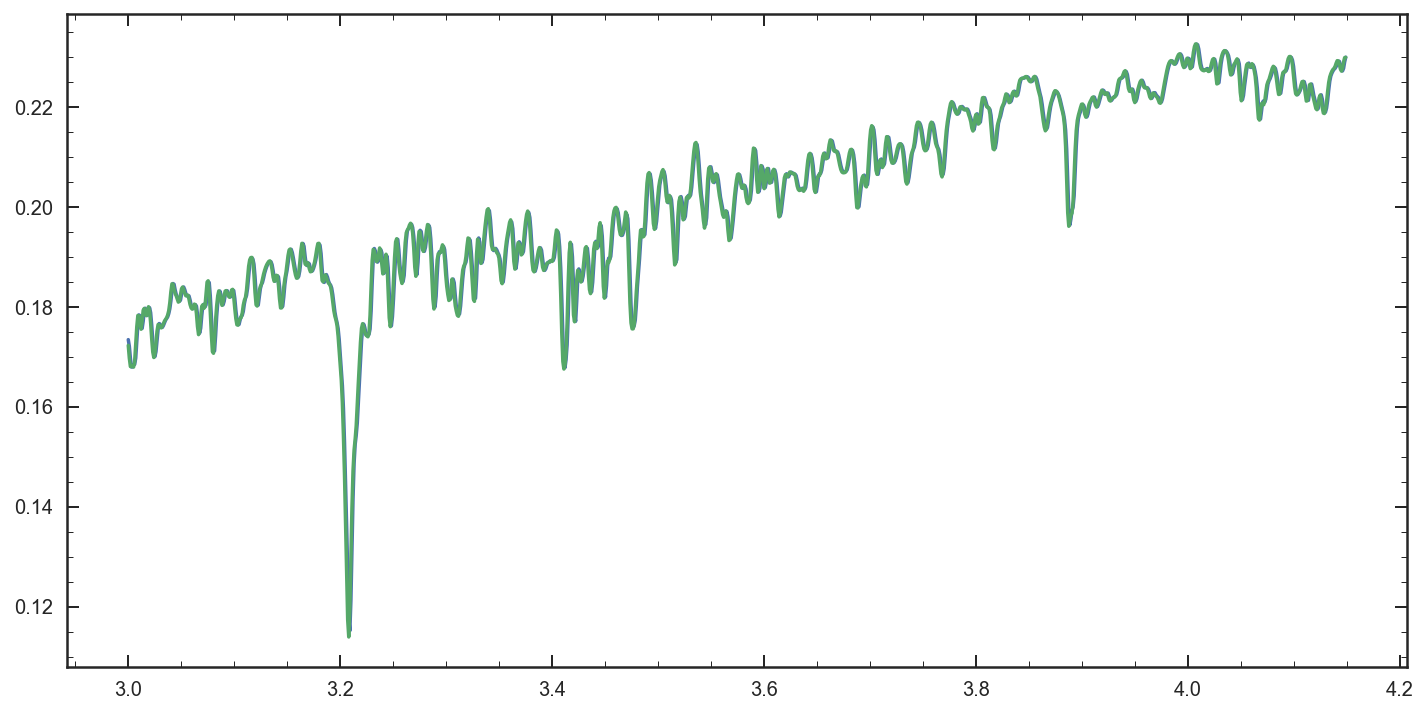

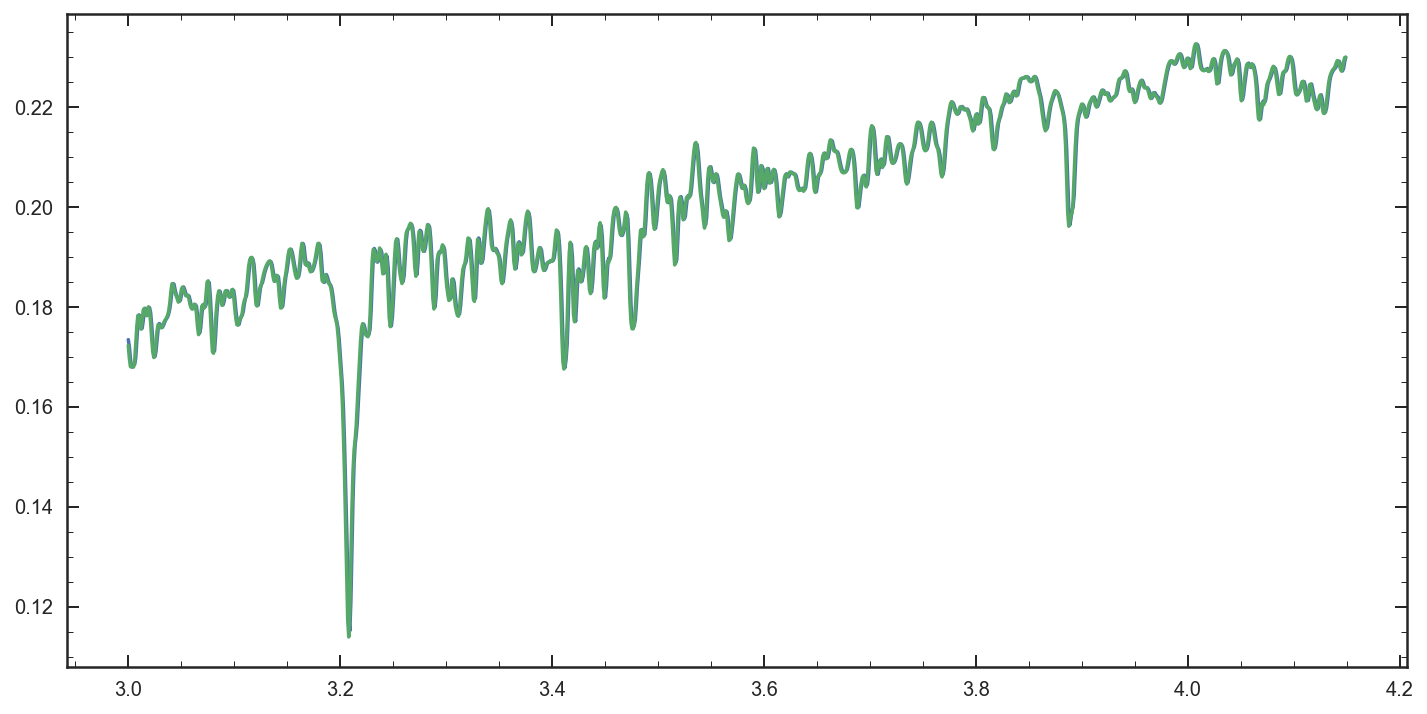

In [40]:
plt.figure(figsize=[12,6])
plt.plot(rwv,rtrans)
plt.plot(cwv,ctrans)

plt.figure(figsize=[12,6])
plt.plot(d_grismr[0],d_grismr[1]/rtrans)
plt.plot(d_grismc[0],1.0436*d_grismc[1]/ctrans)

plt.figure(figsize=[12,6])
plt.plot(m_grismr[0],m_grismr[1]/rtrans)
plt.plot(m_grismc[0],1.04360286572*m_grismc[1]/ctrans)


In [97]:
H = ksmooth.dpik(stack)
sm_stack= ksmooth.locpoly(wv,stack,bandwidth = .005)
X = np.array(sm_stack[0])
iFX = np.array(sm_stack[1])
# Fx = interp1d(X,iFX)(x)

In [89]:
ksmooth.dpik(stack)

R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x115699d88 / R:0x7fad442c0388>
[0.001875]

(0, 0.4)

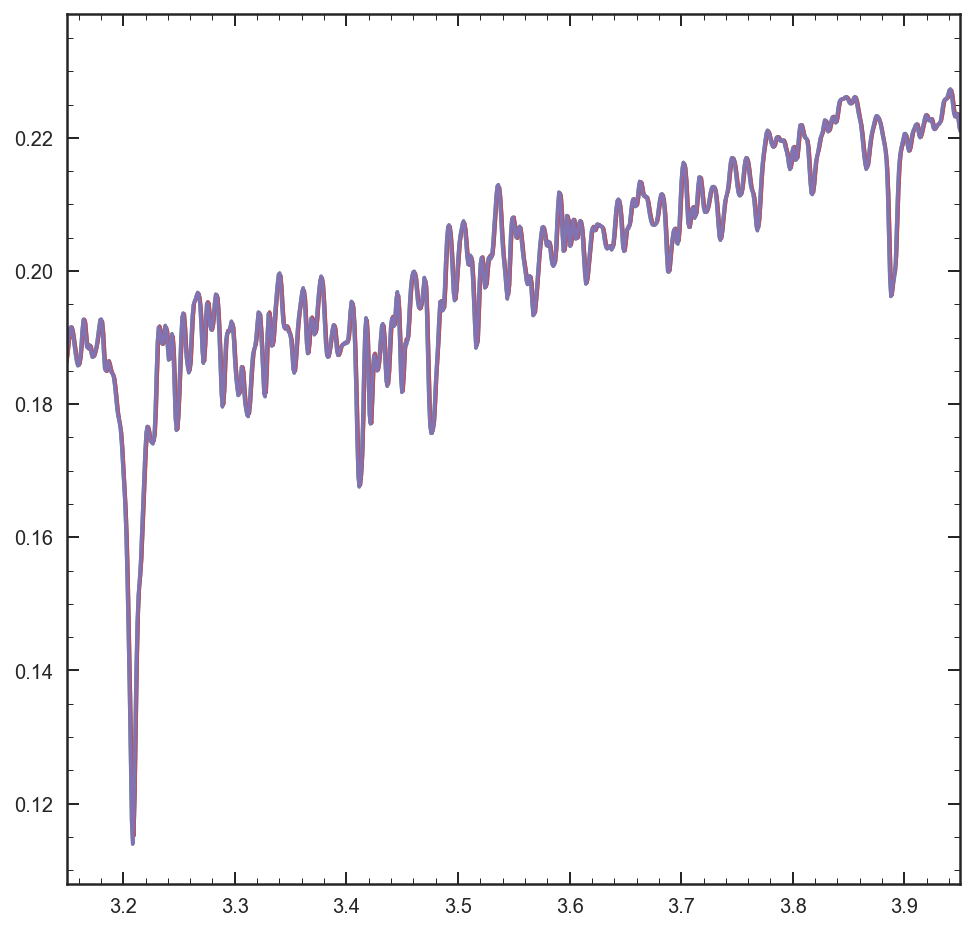

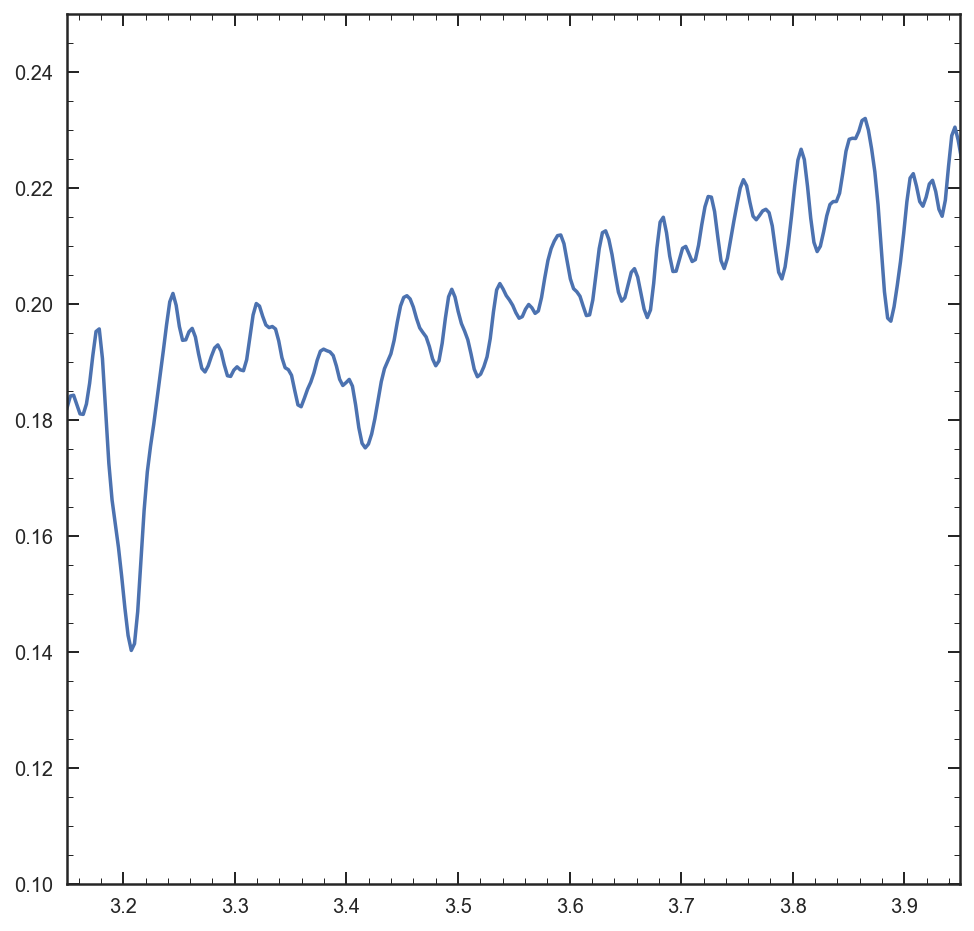

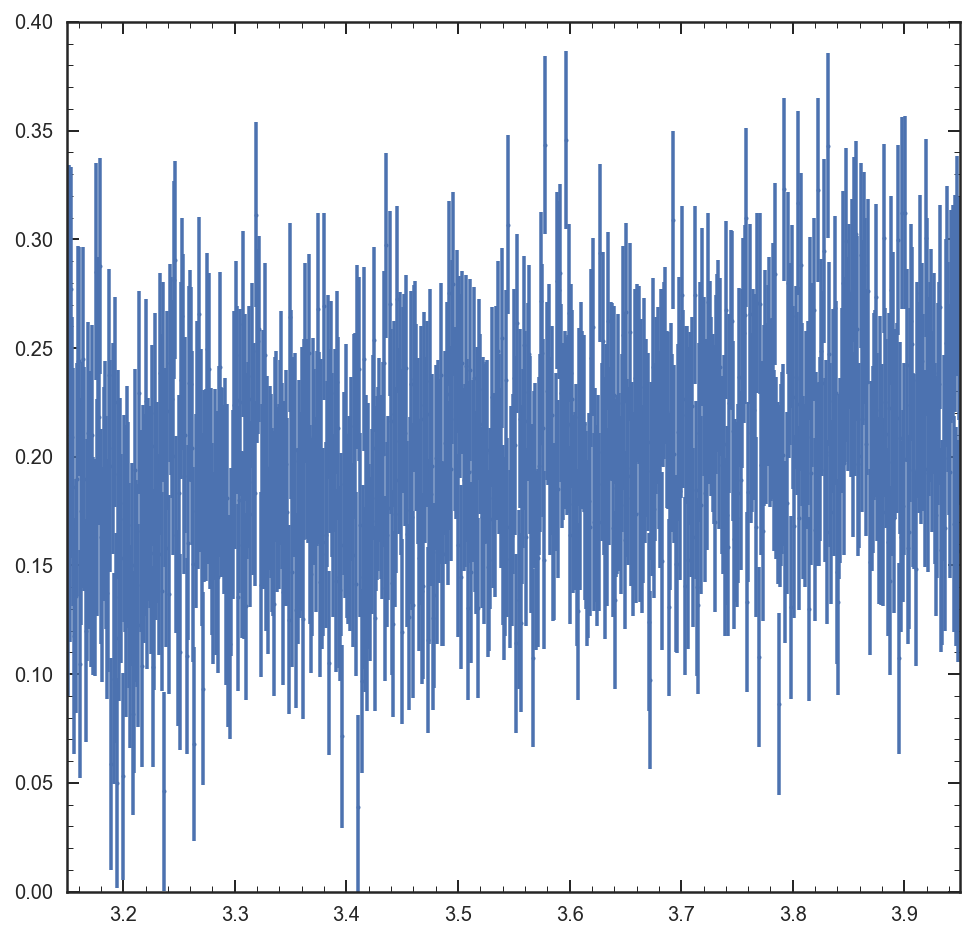

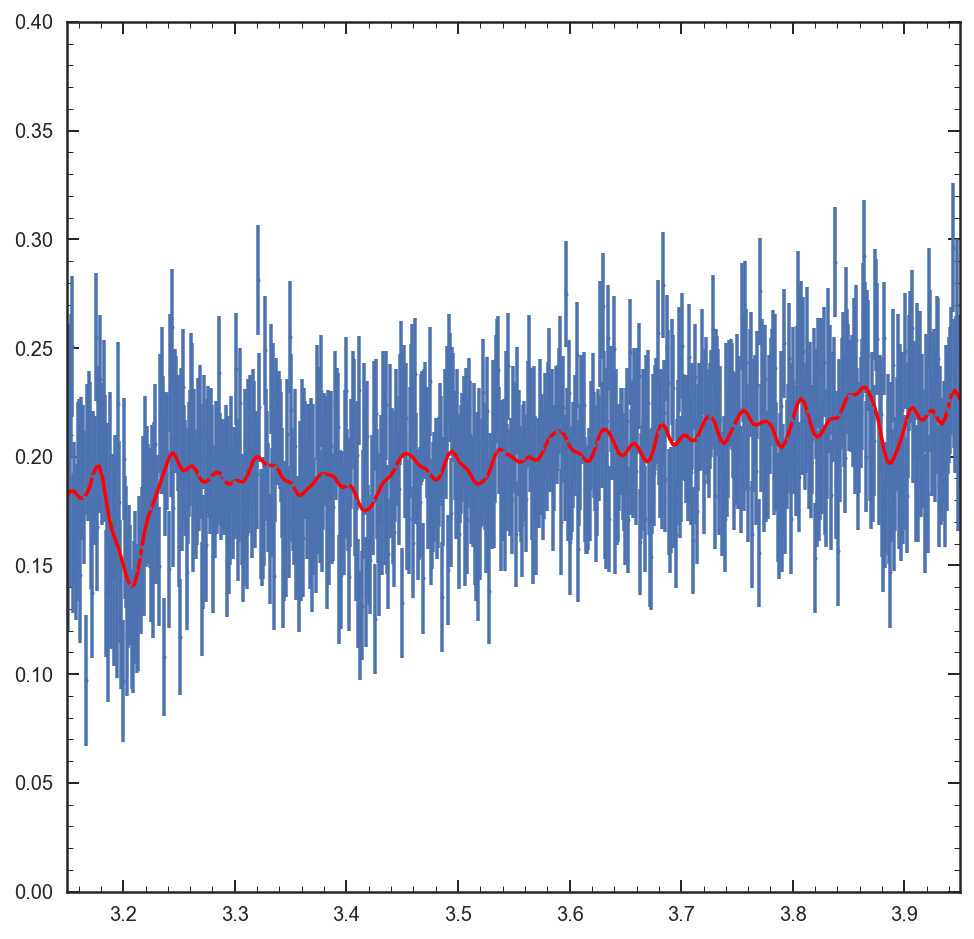

In [98]:
plt.figure(figsize=[8,8])
plt.plot(wv,dgr_fn)
plt.plot(wv,dgc_fn)
plt.plot(wv,mgr_fn)
plt.plot(wv,mgc_fn)
plt.xlim(3.15,3.95)

plt.figure(figsize=[8,8])
plt.plot(X,iFX)
plt.xlim(3.15,3.95)
plt.ylim(0.1,.25)

plt.figure(figsize=[8,8])
plt.errorbar(wv,sim_drfn,dgr_er,fmt='o',ms=2)
plt.xlim(3.15,3.95)
plt.ylim(0,.4)

plt.figure(figsize=[8,8])
plt.errorbar(wv,stack,error,fmt='o',ms=2)
plt.plot(X,iFX,'r')
plt.xlim(3.15,3.95)
plt.ylim(0,.4)
